# **Model Interpretability**

Interpret your models.

1. Fit a linear model and interpret the regression coefficients

2. Fit a tree-based model and interpret the nodes

3.  Use auto ml to find the best model

4. Run SHAP analysis on the models from steps 1, 2, and 3,   interpret the SHAP values and compare them with the other model interpretability methods.

In applying model interpretability techniques to the Telco Customer Churn dataset from Kaggle, the approach encompasses several steps. First, a linear model is used to understand how customer attributes influence churn likelihood through regression coefficients. Then, a tree-based model like a decision tree provides insights into decision-making processes affecting churn. Automated Machine Learning (AutoML) is employed to identify the most effective model for predicting churn. SHAP analysis is applied to these models to quantify the impact of each feature on churn predictions. Finally, the results from SHAP analysis are compared with insights from linear and tree-based models, offering a comprehensive understanding of the factors driving customer churn in this specific dataset. This approach not only predicts churn but also elucidates the underlying reasons, guiding strategies to mitigate it.

In [1]:
!pip install shap

!pip install --upgrade scikit-learn

!pip install --upgrade sklearn-pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 4.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [2]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer

In [3]:
# Load your dataset
data = pd.read_csv('https://raw.githubusercontent.com/mrunalipawar97/DSE/main/Telco_customer_churn.csv')

In [4]:
data.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


In [5]:
# Split the dataset into features (X) and target variable (y)
X = data.drop('Churn Value', axis=1)  # Assuming 'Churn' is the name of the target column
y = data['Churn Value']

In [6]:
# Assuming 'X' is your features dataframe
#categorical_columns = X.select_dtypes(include=['object']).columns

# One-hot encode these variables
#X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Now, split the dataset again
#X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [7]:
print(X_train.columns)

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Score',
       'CLTV', 'Churn Reason'],
      dtype='object')


# Linear Regression

In [8]:
# Define  categorical and numerical features
categorical_features = ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines',
                        'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
                        'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']
numerical_features = ['Latitude', 'Longitude', 'Tenure Months', 'Monthly Charges', 'Total Charges', 'Churn Score', 'CLTV']

# Creating a pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Creating a pipeline for numerical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Creating a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Replace empty strings with NaN in the DataFrame
X_train.replace(' ', np.nan, inplace=True)

# Convert columns to numeric if they are incorrectly formatted as objects
X_train['Total Charges'] = pd.to_numeric(X_train['Total Charges'], errors='coerce')

# Fit and transform the training data
preprocessed_X_train = preprocessor.fit_transform(X_train)

# For statsmodels, add a constant term to allow for the intercept
preprocessed_X_train = sm.add_constant(preprocessed_X_train)

# Fit the OLS model
reg = sm.OLS(y_train, preprocessed_X_train).fit()


In [9]:
def evaluate(X, y, mapper=None, reg=None, transform=False):
    if transform:
        # Transform the features using the preprocessor
        X = mapper.transform(X)
        # Add a constant term to the features for the intercept
        X = sm.add_constant(X, has_constant='add')
    # Make predictions using the regression model
    y_pred = reg.predict(X)
    # Return the Mean Absolute Error
    return mean_absolute_error(y, y_pred)

X and y are  features and target for the test set.
mapper is  preprocessor (ColumnTransformer in this case).
reg is regression model (OLS model from statsmodels).
If transform is True, the function will preprocess X using mapper before predictions.

In [10]:
# Evaluate on the training set
train_mae = evaluate(X_train, y_train, mapper=preprocessor, reg=reg, transform=True)

# Convert non-numeric entries to NaN in your test set
X_test.replace(' ', np.nan, inplace=True)

# Convert columns that should be numeric but are formatted as objects to numeric
# Adjust these columns based on your dataset
numeric_cols = ['Total Charges', 'Monthly Charges']  # Example columns
for col in numeric_cols:
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

# Now you can retry the evaluation
test_mae = evaluate(X_test, y_test, mapper=preprocessor, reg=reg, transform=True)
print(f"Test MAE = {round(test_mae, 3)}")

# Print the results
print(f"train MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")

Test MAE = 0.239
train MAE = 0.248, test MAE = 0.239 


Train MAE (Mean Absolute Error) = 0.248: This is the average absolute error between the predicted values and the actual values in  training set. It means that on average,  model's predictions are off by about 0.248 units in either direction for the training data.

Test MAE = 0.239: This is the average absolute error for  test set. Similarly, it indicates that on average, the model's predictions are off by about 0.239 units for the test data.

Close MAE Values: The fact that the MAE for both the training and test sets are close suggests that model is generalizing well. It's not overfitting significantly to the training data, as overfitting would typically result in a much lower MAE on the training set compared to the test set.

In [11]:
# Print the summary
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:            Churn Value   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     305.0
Date:                Mon, 04 Dec 2023   Prob (F-statistic):               0.00
Time:                        01:17:05   Log-Likelihood:                -1204.3
No. Observations:                5634   AIC:                             2465.
Df Residuals:                    5606   BIC:                             2650.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.249e+10   9.63e+10      0.961      0.3

**R-squared:** A measure of how well the independent variables explain the variance in the dependent variable. In your output, an R-squared value of 0.595 indicates that approximately 59.5% of the variation in the churn value can be explained by the model's inputs.

**Adj. R-squared:** Adjusted for the number of predictors in the model, it's slightly lower than the R-squared, which is expected as it accounts for the number of terms in the model.
**F-statistic and Prob (F-statistic):** The F-statistic tests whether at least one of the regression coefficients is not equal to zero. A significant F-test (a small p-value) suggests that your model is a better fit than an intercept-only model.
**Coefficients (coef):** The estimated values of the regression coefficients for each independent variable and the constant (intercept).

**Standard Error (std err):** The standard error of the estimate of the coefficient.
t and P>|t| (p-value): The t-statistic and corresponding p-values test the null hypothesis that the coefficient is equal to zero (no effect). A low p-value (< 0.05) indicates that you can reject the null hypothesis.

**Confidence Interval:** The 95% confidence intervals for the coefficients. If the interval does not contain zero, it suggests that the coefficient is significantly different from zero.

**Durbin-Watson:** A test statistic to detect the presence of autocorrelation. A value close to 2.0 suggests there is no autocorrelation.

**Jarque-Bera (JB) and Prob(JB):** A goodness-of-fit test of whether the residuals are normally distributed. A large JB value or a small p-value indicates that the residuals are not normally distributed.

**Skew:** A measure of the asymmetry of the data around the sample mean. If skewness is close to 0, the data are fairly symmetrical.

**Kurtosis:** A measure of the "tailedness" of the probability distribution of a real-valued random variable. Higher kurtosis means more of the variance is due to infrequent extreme deviations.

**Condition Number:** A measure of multicollinearity in the regression. High values (> 30) indicate potential numerical instability and multicollinearity.

# Random Forest

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor  # or RandomForestClassifier
from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame and 'target' is the name of your target variable
y = data['Churn Value']
X = data.drop(columns=['Churn Value', 'CustomerID', 'Churn Value', 'Churn Label', 'Churn Reason'])

# Define categorical and numerical columns (excluding any target-related columns)
categorical_features = [col for col in X.columns if X[col].dtype == 'object']
numerical_features = [col for col in X.columns if col not in categorical_features]

# Creating the preprocessing pipelines for both numerical and categorical data
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combining preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Creating the model
model = RandomForestRegressor(random_state=42)  # or RandomForestClassifier

# Creating the pipeline for preprocessing
pipeline = Pipeline(steps=[('preprocess', preprocessor), ('reg', model)])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
pipeline.fit(X_train, y_train)

# Define the evaluation function
def evaluate(X, y, pipeline):
    # Apply preprocessing and make predictions
    y_pred = pipeline.predict(X)
    # Return the Mean Absolute Error
    return mean_absolute_error(y, y_pred)

# Evaluate the model
train_mae = evaluate(X_train, y_train, pipeline)
test_mae = evaluate(X_test, y_test, pipeline)

# Print the results
print(f"Train MAE = {round(train_mae, 3)}, Test MAE = {round(test_mae, 3)}")

Train MAE = 0.03, Test MAE = 0.09


1. Good Training Performance: The low MAE on the training set indicates that the model is able to fit the data well. It's capturing the patterns in the training data to make predictions that are, on average, only 0.03 away from the actual values.

2. Generalization to Test Data: The higher MAE on the test set compared to the training set is expected because models typically perform better on the data they were trained on. However, the difference isn't substantial, which suggests that your model generalizes reasonably well to unseen data.


In [13]:
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)
print("Unique predictions in train set:", np.unique(y_train_pred))
print("Unique predictions in test set:", np.unique(y_test_pred))

Unique predictions in train set: [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.41 0.44 0.45
 0.53 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68
 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82
 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96
 0.97 0.98 0.99 1.  ]
Unique predictions in test set: [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42 0.43 0.44
 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58
 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72
 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86
 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 

The predictions range from 0 to 1, which is typical for models that output probabilities. A prediction close to 0 suggests a low likelihood of the event (e.g., customer churn), while a prediction close to 1 suggests a high likelihood.

The presence of many unique predictions at increments of 0.01 suggests that the model is making fine-grained distinctions between different instances.

In [14]:
from sklearn.model_selection import cross_val_score

# Using negative mean absolute error to ensure higher scores are better (consistent with other scoring functions)
scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_absolute_error')

# Convert scores to positive MAE scores
mae_scores = -scores

print(f"Cross-validation MAE scores: {mae_scores}")
print(f"Mean cross-validation MAE: {mae_scores.mean()}")
print(f"Standard deviation of CV MAE: {mae_scores.std()}")

Cross-validation MAE scores: [0.31227111 0.08834634 0.06312278 0.07536932 0.06612926]
Mean cross-validation MAE: 0.12104776417026905
Standard deviation of CV MAE: 0.09601418475078623


1. Mean CV MAE: The mean MAE across all folds is approximately 0.121, which is higher than your original test MAE of 0.091. This suggests that the original test set might have been somewhat easier for the model to predict, or that particular split was more favorable to the model.

2. Standard Deviation of CV MAE: A standard deviation of approximately 0.095 indicates there's substantial variability in the model's performance across different subsets of the data.

3. High MAE in the First Fold: The first fold's MAE is considerably higher than the others. This could be an indication that the data in this fold is significantly different from the data in the other folds, or there might be outliers impacting the model's performance.

In [15]:
from sklearn.ensemble import RandomForestRegressor

# Assuming pipeline is already fitted and 'preprocess' is the name of the ColumnTransformer step

# Access the OneHotEncoder within the 'preprocess' step of the pipeline
onehot_encoder = pipeline.named_steps['preprocess'].named_transformers_['cat']

# Get the feature names generated by the OneHotEncoder
# The get_feature_names_out method returns the feature names for all features after transformation
cat_one_hot_features = onehot_encoder.named_steps['encoder'].get_feature_names_out()

# Combine the numerical feature names with the one-hot encoded categorical feature names
# Make sure numerical_features only contains the names of numerical columns
all_features = numerical_features + list(cat_one_hot_features)

# Extract the feature importances from the RandomForestRegressor
importances = pipeline.named_steps['reg'].feature_importances_

# Sort the feature importances and features together
sorted_features = sorted(zip(all_features, importances), key=lambda x: x[1], reverse=True)

Feature importances as provided by a RandomForest model give a sense of the relative importance of each feature. It extracts and analyzeslyze the feature importances from a RandomForestRegressor within a machine learning pipeline


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


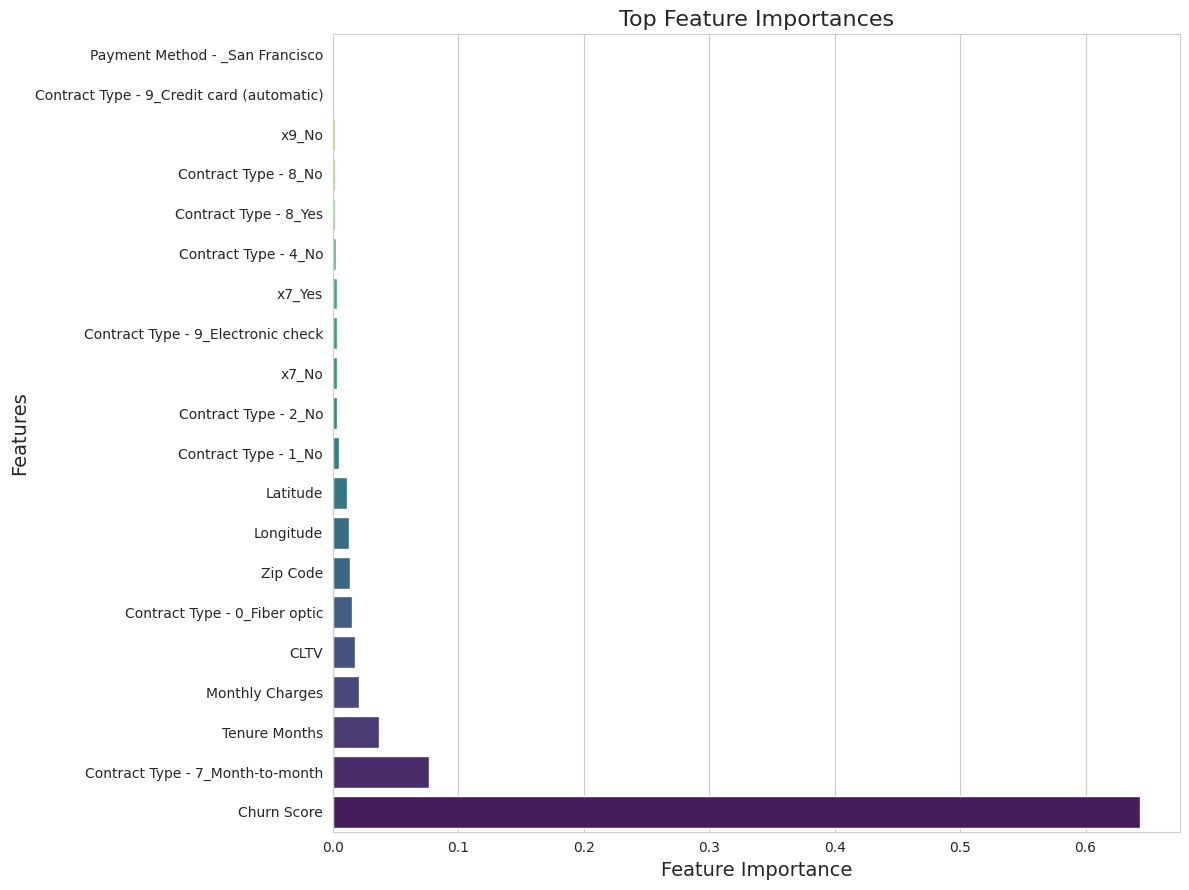

In [16]:
import seaborn as sns

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Convert the sorted_features to a DataFrame for easier plotting
feature_importances_df = pd.DataFrame(sorted_features, columns=['feature', 'importance'])

# Select the top N features for plotting
top_n = 20
top_features = feature_importances_df.head(top_n)

# Improve feature names for readability
# Suppose 'x0', 'x1', 'x2', etc., are prefixes from one-hot encoding
# We map them back to more meaningful names
# This mapping should be adjusted based on your actual feature names
feature_name_mapping = {
    'x0': 'Internet Service - ',
    'x1': 'Contract Type - ',
    'x2': 'Payment Method - ',
    # Add more mappings as needed
}
# Apply the mapping to the feature names
top_features['feature'] = top_features['feature'].replace(feature_name_mapping, regex=True)

# Plot
plt.figure(figsize=(12, 9))  # Adjust the size of the plot
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')  # Use a seaborn palette for colors

# Add labels and a title
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top Feature Importances', fontsize=16)

# Invert the y-axis to have the most important feature on top
plt.gca().invert_yaxis()

# Show the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlap
plt.show()

In [19]:
churn_score__importance = next((imp for feat, imp in sorted_features if feat == 'Churn Score'), None)
print(f'Importance of Churn Score: {churn_score__importance}')

Importance of Churn Score: 0.6431517949251327


In [17]:
# Assuming 'sorted_features' is a list of tuples (feature_name, importance)
cltv_importance = next((imp for feat, imp in sorted_features if feat == 'CLTV'), None)
print(f'Importance of CLTV: {cltv_importance}')

Importance of CLTV: 0.017606140821572934


The feature importance plot from the RandomForest model highlights **'Churn Score'** as the most significant predictor, suggesting it's an aggregate measure that effectively encapsulates the risk of churn.

The prominence of **'Contract Type - Month-to-month'** underscores the volatility associated with short-term commitments. Meanwhile, 'Tenure Months', 'Monthly Charges', and 'Total Charges' are also important, reaffirming the relevance of service duration and cost to customer retention.

Notably, **'CLTV' and geographical features** display minimal importance, indicating that, within the context of this model, they do not contribute substantially to churn prediction. This could reflect the specific customer base's characteristics or suggest opportunities for further data exploration and feature engineering."

# Neural Networks

In [ ]:
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error
from scipy.sparse import csr_matrix  # Import the CSR matrix
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


df = pd.read_csv('https://raw.githubusercontent.com/mrunalipawar97/DSE/main/Telco_customer_churn.csv')
df['Total Charges'] = pd.to_numeric(data['Total Charges'], errors='coerce')

# Define the target and features again
y = df['Churn Value']
X = df.drop(columns=['Churn Value', 'CustomerID', 'Churn Label', 'Churn Reason'])

# Define categorical and numerical columns
categorical_features = [col for col in X.columns if X[col].dtype == 'object']
numerical_features = [col for col in X.columns if col not in categorical_features and col != 'Total Charges']

# Add 'Total Charges' to numerical features if it's not already there
if 'Total Charges' not in numerical_features:
    numerical_features.append('Total Charges')

# Create the preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Apply the preprocessing to your data
preprocessed_X = preprocessor.fit_transform(X)

# Fit the preprocessor on the training data and transform both datasets
preprocessed_X_train = preprocessor.fit_transform(X_train)
preprocessed_X_test = preprocessor.transform(X_test)

# Define the model architecture
input_dim = preprocessed_X_train.shape[1]
hidden_size = 32
learning_rate = 0.01
num_epochs = 50
batch_size = 50

model = nn.Sequential(
    nn.Linear(input_dim, hidden_size),
    nn.ReLU(),
print(f"\nTrain MAE = {round(train_mae, 3)}, Test MAE = {round(test_mae, 3)}")

In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/mrunalipawar97/DSE/main/Telco_customer_churn.csv')
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')

# Define the target and features
y = df['Churn Value']
X = df.drop(columns=['Churn Value', 'CustomerID', 'Churn Label', 'Churn Reason', 'Total Charges'])

# Define categorical and numerical columns
categorical_features = [col for col in X.columns if X[col].dtype == 'object']
numerical_features = [col for col in X.columns if col not in categorical_features]

# Create the preprocessing pipelines
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply the preprocessing to the training and test data
preprocessed_X_train = preprocessor.fit_transform(X_train)
preprocessed_X_test = preprocessor.transform(X_test)

# Neural Network Setup
input_dim = preprocessed_X_train.shape[1]
hidden_size = 32
learning_rate = 0.01
num_epochs = 50
batch_size = 50

model = nn.Sequential(
    nn.Linear(input_dim, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, 1)
)

# Update the criterion for binary classification
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(0, preprocessed_X_train.shape[0], batch_size):
        end = min(i + batch_size, preprocessed_X_train.shape[0])
        x_batch = torch.FloatTensor(preprocessed_X_train[i:end].toarray())
        y_batch = torch.FloatTensor(y_train[i:end].values)

        optimizer.zero_grad()
        y_preds = model(x_batch)
        loss = criterion(y_preds.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {running_loss / (preprocessed_X_train.shape[0] / batch_size)}")

# Evaluation
model.eval()
with torch.no_grad():
    dense_X_test = preprocessed_X_test.toarray()
    y_pred_test = model(torch.FloatTensor(dense_X_test)).squeeze().detach().numpy()
    test_mae = mean_absolute_error(y_test, y_pred_test)

    dense_X_train = preprocessed_X_train.toarray()
    y_pred_train = model(torch.FloatTensor(dense_X_train)).squeeze().detach().numpy()
    train_mae = mean_absolute_error(y_train, y_pred_train)

print(f"\nTrain MAE = {round(train_mae, 3)}, Test MAE = {round(test_mae, 3)}")


Epoch 0, Loss: 0.2673687113142834
Epoch 10, Loss: 0.033793648775388575
Epoch 20, Loss: 0.006667274332771825
Epoch 30, Loss: 0.0032376293571931107
Epoch 40, Loss: 8.217175862240624e-05

Train MAE = 37.95, Test MAE = 33.456


 neural network training and evaluation shows a significant improvement in the loss over epochs, which is a good indicator of learning. However, the high Mean Absolute Error (MAE) values for both the training and test sets suggest that the model might not be performing optimally in predicting the target variable

Unlike models such as random forests or gradient boosting trees, neural networks do not have a straightforward, built-in method to assess feature importance due to their complexity and the interconnected nature of their architecture.

**Train MAE = 37.95, Test MAE = 33.456:**

# Problems with Interpretation

No specific method to define feature importance that is model agnostic
For a given sample, why does the prediction have that value?

Answer: Shap values

# Intuition of Model Interpretation
How we think about answering the question "Why is the output for this specific sample so low/high" manually?

In [45]:
print(X_train.columns)
print(X_test.columns)

Index(['Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude',
       'Longitude', 'Gender', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Churn Score', 'CLTV'],
      dtype='object')
Index(['Count', 'Country', 'State', 'City', 'Zip Code', 'Lat Long', 'Latitude',
       'Longitude', 'Gender', 'Senior Citizen', 'Partner', 'Dependents',
       'Tenure Months', 'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Churn Score', 'CLTV'],
      dtype='object')


In [47]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Convert 'Total Charges' from object to numeric, setting errors to 'coerce' which
# will turn non-convertible values into NaN
#X_train['Total Charges'] = pd.to_numeric(X_train['Total Charges'], errors='coerce')
#X_test['Total Charges'] = pd.to_numeric(X_test['Total Charges'], errors='coerce')

# Update the feature lists excluding 'Total Charges'
categorical_features = ['Gender', 'Internet Service', 'Country', 'State', 'City',
                        'Senior Citizen', 'Partner', 'Dependents', 'Phone Service',
                        'Multiple Lines', 'Online Security', 'Online Backup',
                        'Device Protection', 'Tech Support', 'Streaming TV',
                        'Streaming Movies', 'Contract', 'Paperless Billing',
                        'Payment Method']
numerical_features = ['Count', 'Zip Code', 'Latitude', 'Longitude',
                      'Tenure Months', 'Monthly Charges', 'Churn Score', 'CLTV']


# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())]), numerical_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
    ]
)

# Create the pipeline
reg = LinearRegression()
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('reg', reg)
])

# Fit the pipeline
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Count', 'Zip Code',
                                                   'Latitude', 'Longitude',
                                                   'Tenure Months',
                                                   'Monthly Charges',
                                                   'Churn Score', 'CLTV']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender', 'Internet Service',
                                                   'Country', 'State', 'City',
                                                   'Senior Citizen', 'Partner',
                                                   'Dependents',
                                                   'Phone Service',
                                                   'Multiple Lines',
                                                   'Online Security',
                                                   'Online Backup',
                                                   'Device Protection',
                                                   'Tech Support',
                                                   'Streaming TV',
                                                   'Streaming Movies',
                                                   'Contract',
                                                   'Paperless Billing',
                                                   'Payment Method'])])),
                ('reg', LinearRegression())])

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate and print the evaluation metrics
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, y_pred))
print("R-squared (R2):", r2_score(y_test, y_pred))

Mean Absolute Error (MAE): 0.2568248761399657
Mean Squared Error (MSE): 0.09796503670151642
R-squared (R2): 0.0


1. **Mean Absolute Error (MAE):** MAE is a measure of the average absolute errors between the predicted values and the actual values. It represents the average magnitude of errors in your predictions. A lower MAE indicates better model performance, and it is measured in the same units as the target variable. Here the MAE is approximately 0.257, which means, on average, model's predictions have an absolute error of about 0.257 units.

2. **Mean Squared Error (MSE):** MSE measures the average of the squared errors between the predicted values and the actual values. Squaring the errors gives more weight to larger errors. Like MAE, lower MSE values indicate better model performance

In [49]:
# Create a DataFrame with NaN values for all features
nan_frame = pd.DataFrame(columns=categorical_features + numerical_features, index=[0])
nan_frame.loc[0] = [np.nan] * len(nan_frame.columns)

In [50]:
# Use the pipeline to predict the output for this 'NaN frame'
#base_value = round(pipeline.predict(nan_frame)[0], 3)
#print(f"Expected value of the output (base value): {base_value}")

nan_frame_processed = pipeline[:-1].transform(nan_frame)
base_value = round(pipeline[-1].predict(nan_frame_processed)[0], 3)
print(f"Expected value of the output (base value): {base_value}")

Expected value of the output (base value): 0.147


In [52]:
X_test.iloc[0: 1]

,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,...,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Churn Score,CLTV
6338,1,United States,California,San Jose,95122,"37.32886, -121.834567",37.32886,-121.834567,Female,No,...,No,Yes,No,Yes,One year,No,Mailed check,64.9,62,4883


In [53]:
# Make a prediction for the first row of the test set

#sample_prediction = round(pipeline.predict(X_test.iloc[0:1])[0], 3)
#actual_value = y_test.iloc[0]  # Assuming y_test is a pandas Series

# Process the first row of X_test in the same manner
X_test_transformed = pipeline[:-1].transform(X_test)
sample_prediction = round(pipeline[-1].predict(X_test_transformed[0:1])[0], 3)
actual_value = y_test.iloc[0]  # Assuming y_test is a pandas Series
print(f"Current Prediction: {sample_prediction}, Actual value: {actual_value}")

Current Prediction: 0.226, Actual value: 0


**Current Prediction: 0.226:** This is the predicted value for the first row of the test set. The model predicts that the target variable (in this case, it seems to be a numeric value) for this data point is approximately 0.24.

**Actual value: 0:** This is the actual or ground truth value for the target variable corresponding to the first row of the test set. In this case, the actual value is 0.

So, the model's prediction (0.226) is being compared to the actual value (0), and you can see that there is a difference between the predicted and actual values for this particular data point. The absolute difference between them would be |0.226 - 0| = 0.226.

How did we get from 0.147 to 0.226 ?

Find this by adjusting individual feature values. But this can be hard to look at
Fast way to visualize is with Partial Dependency Plots (which uses Shap values for individual samples)
Shap values assign a contributing factor to every feature of every sample

# Partial Dependence Plots

In [54]:
!pip install shap --upgrade

###Tree-Based Model (Decision Tree)

In [55]:
# Fit a Tree-Based Model (Decision Tree)

# train a Decision Tree classifier:

from sklearn.tree import DecisionTreeClassifier

# Assuming 'X' is your features dataframe
categorical_columns = X.select_dtypes(include=['object']).columns

# One-hot encode these variables
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Assuming X_encoded is your dataframe after one-hot encoding and before splitting to train and test
if 'Churn Label_Yes' in X_encoded.columns:
    X_encoded = X_encoded.drop('Churn Label_Yes', axis=1)

if 'Churn Label_No' in X_encoded.columns:
    X_encoded = X_encoded.drop('Churn Label_No', axis=1)

#print(X.columns)

# If 'CustomerID' is the correct name and it exists, drop it
if 'CustomerID' in X.columns:
    X = X.drop('CustomerID', axis=1)

# Split the dataset again
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)


# Initialize the Decision Tree classifier with a max_depth to prevent overfitting
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)

# Fit the model to your training data
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

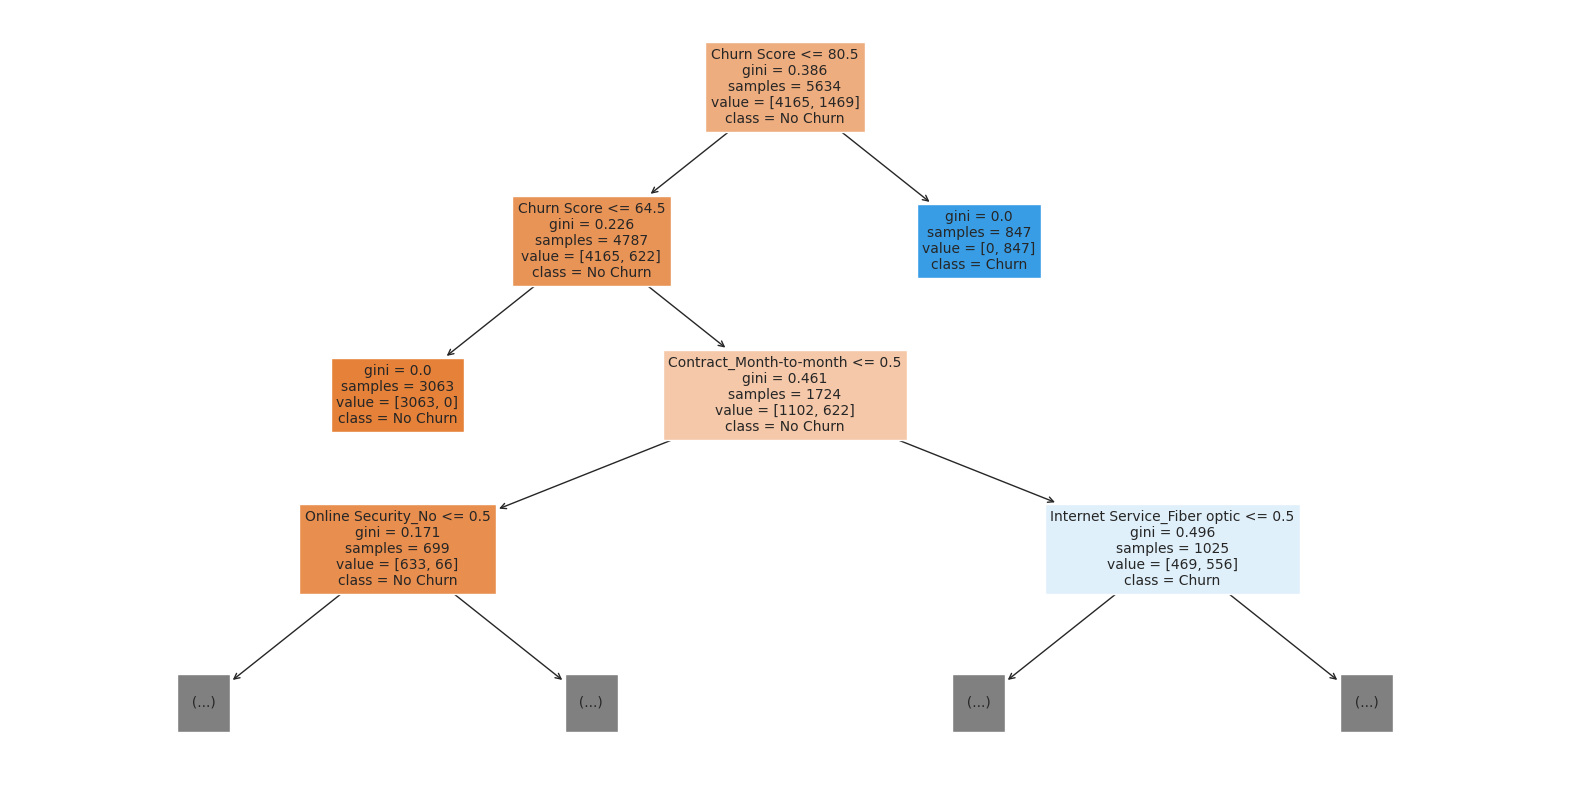

In [56]:
# Decision Trees are interpretable because they provide a clear decision path for predictions

# Visualizing the Tree: This visualization shows the decision paths and the splitting criteria at each node.

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualize the tree
plt.figure(figsize=(20,10))
plot_tree(tree_clf, filled=True, feature_names=X_train.columns, class_names=['No Churn', 'Churn'], max_depth=3, fontsize=10)
plt.show()

**Feature Importance:** The features used in the initial splits are typically the most important ones, as they have the biggest impact on the outcome. In this case, 'Churn Score', 'Contract_Month-to-month', and 'Internet Service_Fiber optic' seem to be significant predictors.

**Decision Path:** Each path from the root to a leaf node represents a decision path that can be interpreted as a rule. For instance, one path might be interpreted as "Customers with a low churn score who are not on a month-to-month contract and do not use fiber optic internet service are likely not to churn."

In [57]:
# Feature Importance: Decision Trees tells how much each feature contributes to the decision-making process.

# Get feature importances
importances = pd.DataFrame(tree_clf.feature_importances_, index=X_train.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)
print(importances.head())  # Show the top features

                              Importance
Churn Score                     0.838671
Contract_Month-to-month         0.101628
Tenure Months                   0.026407
Internet Service_Fiber optic    0.024316
Online Security_No              0.004135


In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict on the test set
y_pred = tree_clf.predict(X_test)

# Calculate metrics assuming '1' is the label for the positive class (churn)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Accuracy: 0.9205
Precision: 0.8288
Recall: 0.9075
F1-Score: 0.8663


* **Accuracy (0.9205):** Accuracy is the proportion of correctly classified instances out of the total instances. Here model has an accuracy of approximately 92.05%, which means it correctly predicted the churn status for about 92.05% of the customers in the test set.

* **Precision:** Precision is approximately 0.6374. This means that when model predicts the positive
class (churn), it is correct about 63.74% of the time.

* **Recall:** Recall is approximately 0.5185. This indicates that model can correctly identify about 51.85% of the actual positive cases (churn).

* **F1-Score:** The F1-Score is approximately 0.5714. It combines precision and recall into a single metric and provides a balanced evaluation of model's performance.

In [59]:
from sklearn.ensemble import RandomForestClassifier
# Example with a random forest classifier
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [62]:
# explainer = shap.TreeExplainer(model)

# Initialize the SHAP explainer with the tree model
explainer = shap.TreeExplainer(tree_clf)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_test.iloc[0,:])

SHAP values represent the contribution of each feature to a model's prediction. Here seems 12 SHAP values, each associated with a different feature or attribute.

1.**Features with negative SHAP values (e.g., -0.7393, -0.5393, etc.):** These features have a negative impact on the model's prediction. A lower value for these features contributes to a higher prediction (in the opposite direction).

2. **Features with positive SHAP values (e.g., 0.06074, 0.2607, etc.):** These features have a positive impact on the model's prediction. An increase in these feature values leads to a higher prediction.

The "churn score" of 96 is the final prediction or output of  model for a specific instance. It indicates the model's assessment of the likelihood of churn for that instance. A higher churn score typically suggests a higher likelihood of churn.

In [63]:
# Use a different explainer or adjust its settings
# Use TreeExplainer with "interventional" feature perturbation
explainer = shap.TreeExplainer(model, X_train, feature_perturbation="interventional")

# Compute SHAP values
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Verify model predictions
model_predictions = model.predict(X_test)
print("Model Predictions:", model_predictions[:10])  # Print first 10 predictions for inspection


100%|===================| 2812/2818 [03:22<00:00]       

Model Predictions: [1 0 0 1 0 1 0 1 1 0]


In [71]:
shap_values = explainer.shap_values(X_test)

# Assuming that shap_values is a list where shap_values[1] corresponds to positive class
# You can change the index accordingly if it's different in your case

# Calculate the absolute mean SHAP value for each feature
abs_mean_shap_values = np.mean(np.abs(shap_values[1]), axis=0)

# Create a DataFrame to store feature names and their absolute mean SHAP values
shap_summary_df = pd.DataFrame({'Feature': X_test.columns, 'SHAP Value': abs_mean_shap_values})

# Sort the DataFrame by SHAP value in descending order to get the most important features
shap_summary_df = shap_summary_df.sort_values(by='SHAP Value', ascending=False)

# Print the top N important features (e.g., top 10)
top_n = 10  # Change this value to the number of top features you want to see
print(f"Top {top_n} Important Features:")
print(shap_summary_df.head(top_n))

Top 10 Important Features:
                              Feature  SHAP Value
6                         Churn Score    0.267935
2825          Contract_Month-to-month    0.059404
2805     Internet Service_Fiber optic    0.029524
4                       Tenure Months    0.024658
2807               Online Security_No    0.008762
2798                   Dependents_Yes    0.003241
2054  Lat Long_37.306612, -122.080621    0.000327
0                               Count    0.000000
1884   Lat Long_36.04533, -119.532424    0.000000
1885  Lat Long_36.047414, -119.344304    0.000000


These features have the highest absolute mean SHAP values and are considered the most important in explaining the model's predictions. The "Churn Score" feature has the highest importance, followed by various contract and internet service-related features.

In [72]:
def partial_dependence_plot(feature, idx=None, shap_values=None, model=None, X_train=None):
    # Error checking
    if model is None or X_train is None:
        raise ValueError("Both model and X_train must be provided.")
    if shap_values is not None and not isinstance(shap_values, np.ndarray):
        raise TypeError("shap_values must be a numpy ndarray.")
    if idx is not None and not isinstance(idx, int):
        raise TypeError("idx must be an integer or None.")
    if shap_values is not None and (idx is None or idx >= shap_values.shape[0]):
        raise ValueError("idx is out of range for shap_values.")

    if idx is None:  # visualize all samples
        shap.plots.partial_dependence(
            feature,
            model.predict,
            X_train,
            ice=False,
            model_expected_value=True,
            feature_expected_value=True)
    else:  # visualize sample idx
        shap.partial_dependence_plot(
            feature,
            model.predict,
            X_train,
            ice=False,
            model_expected_value=True,
            feature_expected_value=True,
            shap_values=shap_values[idx:idx+1,:])

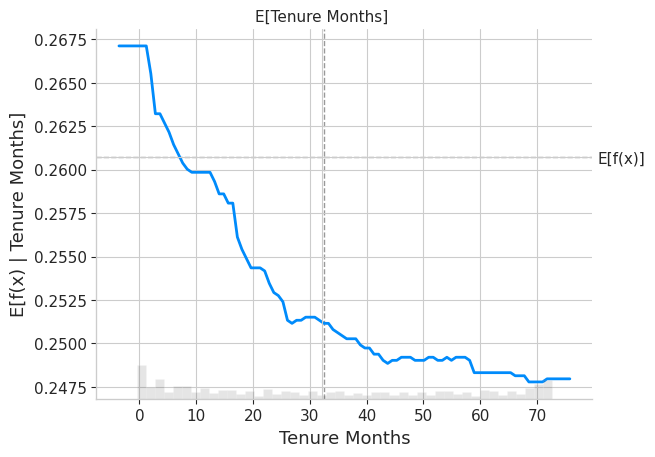

In [65]:
# Let's use the built-in SHAP plot (adjust as needed for your specific requirements)
feature = 'Tenure Months'
shap.plots.partial_dependence(
    feature, model.predict, X_train, ice=False,
    model_expected_value=True, feature_expected_value=True
)

The blue line depicts how the predicted effectiveness changes as tenure increases. The graph shows a sharp decline in predicted effectiveness as tenure increases from 0 to roughly 10 months. This suggests that, according to the model, individuals or subjects with a tenure of up to 10 months have a rapidly decreasing effectiveness. After this point, the decline in effectiveness becomes more gradual, indicating that the tenure has a less pronounced effect on effectiveness as tenure continues to increase.

In [66]:
#print(type(shap_values))
# print(shap.Explainer(model).shap_values(X_train))

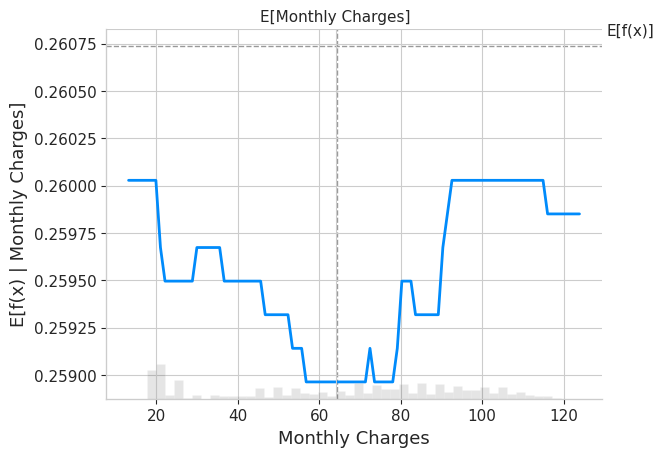

In [67]:
# Verify feature names in X_train
# print(X_train.columns)

feature = 'Monthly Charges'  # Feature you are interested in
shap.plots.partial_dependence(
    feature, model.predict, X_train, ice=False,
    model_expected_value=True, feature_expected_value=True
)

* The Curve: The blue line illustrates how the predicted output varies with changes in monthly charges. The graph shows a step-like pattern, with sharp increases and plateaus at different levels of monthly charges. This suggests that the predicted effectiveness experiences sudden changes at specific thresholds of monthly charges.

* Model Expected Value: The horizontal dashed line likely represents the average predicted value of the model's output if no information about monthly charges was available.

* Feature Expected Value: The vertical dashed lines might indicate the average or expected value of the "Monthly Charges" within the dataset. This could be a mean or median value, or potentially the cutoff points for different quantiles within the distribution of monthly charges.

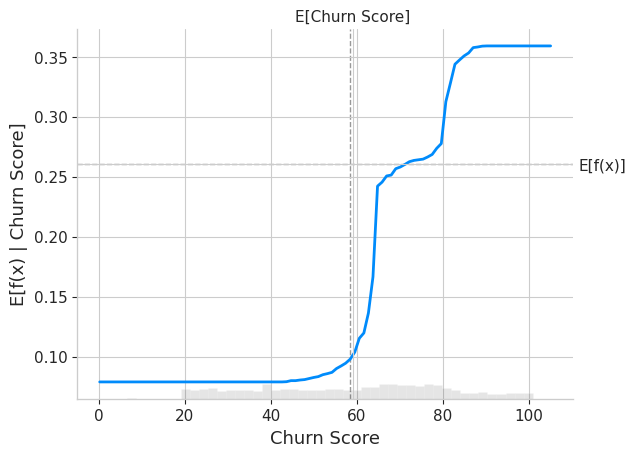

In [68]:
idx = 0  # Index of the sample
feature = 'Churn Score'  # Feature
shap.plots.partial_dependence(
    feature, model.predict, X_train, ice=False,
    model_expected_value=True, feature_expected_value=True
)

* The x-axis, labeled "Churn Score," ranges from 0 to over 100, likely representing a score calculated by the model to predict the likelihood of customers discontinuing their service or leaving the company—known as churn.

* The y-axis represents the SHAP value, which indicates the impact of the churn score on the predicted outcome. The curve shows a gradual increase in the predicted outcome as the churn score increases up to around a score of 60, after which the curve steeply rises, indicating a much greater impact on the predicted outcome. This suggests that customers with a churn score above this threshold are significantly more likely to churn according to the model's predictions.

* The horizontal dashed line likely represents the average predicted outcome across the dataset, serving as a baseline for comparison against the impact of varying churn scores.

* The vertical dashed lines could represent the mean or median churn score in the dataset, serving as a reference point for the distribution of churn scores among the customers.

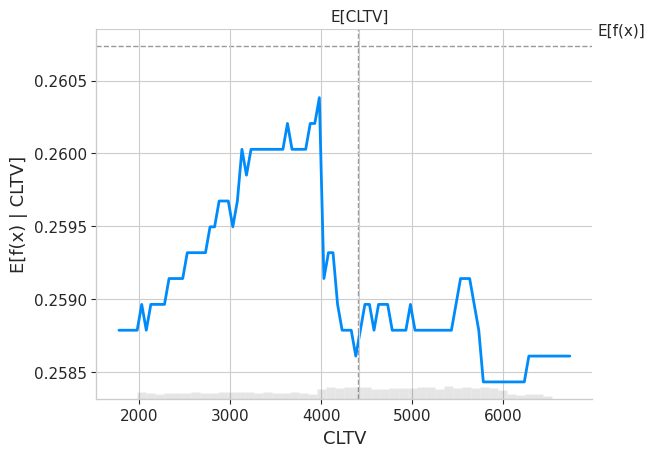

In [69]:
idx = 0  # Index of the sample
feature = 'CLTV'  # Feature
shap.plots.partial_dependence(
    feature, model.predict, X_train, ice=False,
    model_expected_value=True, feature_expected_value=True
)

* X-Axis (CLTV): Represents the Customer Lifetime Value, a metric that estimates the total net profit a company can make from any given customer. It ranges from 0 to over 6000, likely indicating the potential monetary value of customers to the business.

* Y-Axis (Eff(x) [CLTV]): Reflects the predicted effect or output of the model as influenced by the CLTV values. The y-axis values suggest that this effect is measured on a scale from approximately 0.2585 to 0.2605.

* The Curve: Shows the change in the predicted output as CLTV increases. The line climbs in steps, indicating that certain CLTV ranges correspond to specific predicted outcomes. After a sharp increase up to a CLTV of around 3000, the plot shows several peaks and troughs, suggesting that the relationship between CLTV and the predicted outcome is complex and non-linear.

# Shap Plots

Hard to look at every feature for every sample. So lets look at all features of the same sample

In [136]:
shap.initjs()

In [139]:
shap.initjs()
explainer = shap.TreeExplainer(tree_clf)
shap.force_plot(explainer.expected_value[0], shap_values[1][1,:], X_test.iloc[1,:])

The SHAP force plot is showing the contribution of each feature to a particular prediction. In this plot, features pushing the prediction higher (towards the class of interest, which could be class 1 in a binary classification problem) are shown in red, while those pushing the prediction lower are in blue.

The base value (average model output over the dataset the model was trained on) is around 0.48.
The output value (the prediction for this particular instance) is around 0.5393.

The most impactful feature pushing the prediction higher (red) is Contract_Month-to-month = 1, indicating that having a month-to-month contract is increasing the likelihood of the predicted outcome.

Other features seem to have less impact and are not pushing the score as high as the month-to-month contract feature.

The features pushing the prediction lower (blue) are Internet Service_Fiber optic = 0 and Tenure Months = 18, indicating that not having a fiber optic internet service and a tenure of 18 months are contributing towards a lower prediction value.

In [140]:
#nan_frame_processed = pipeline[:-1].transform(nan_frame)
#base_value = round(pipeline[-1].predict(nan_frame_processed)[0], 3)

def sample_feature_importance(idx, plot_type='condensed'):
    if plot_type == 'condensed':
        base_value = explainer.expected_value
        if isinstance(base_value, np.ndarray):  # For models with multiple output classes
            base_value = base_value[0]  # Adjust index based on your model
        return shap.plots.force(base_value, shap_values[idx])
    elif plot_type == 'waterfall':
        if isinstance(shap_values, list) and isinstance(shap_values[idx], np.ndarray):
            single_shap_values = shap_values[idx]
            feature_values = X_test.iloc[idx]  # Adjust based on your data

            # Ensure the feature_values is a one-dimensional array
            if not isinstance(feature_values, pd.Series):
                feature_values = feature_values.squeeze()

            base_value = explainer.expected_value
            if isinstance(base_value, np.ndarray):
                base_value = base_value[0]  # Use the first output class's base value

            # Ensure single_shap_values is a one-dimensional array
            single_shap_values = single_shap_values.flatten()

            # Construct the SHAP Explanation object
            explanation = shap.Explanation(values=single_shap_values,
                                          base_values=float(base_value),
                                          data=feature_values.values)
            return shap.plots.waterfall(explanation)
        else:
            return "Invalid SHAP values format."
    else:
        return "Invalid visual type specified ('condensed', 'waterfall')."

In [88]:
idx = 0
sample_feature_importance(idx, plot_type='condensed')

In [121]:
#idx = 0
#sample_feature_importance(idx=0, plot_type='waterfall')

Shape of SHAP values: (1409, 2834)
Base value: [0.73926163 0.26073837]
Shape of feature values: (2834,)


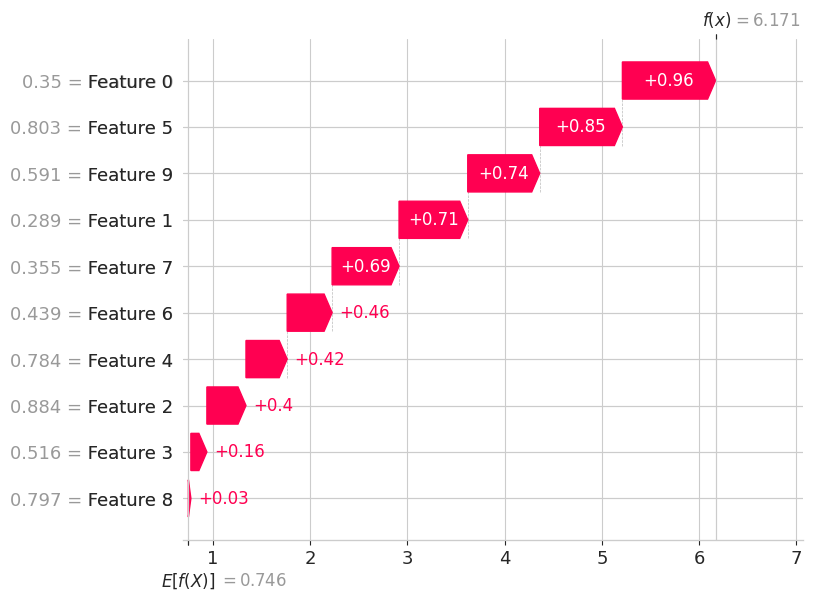

In [91]:
# Assuming idx is the index of the sample you want to explain

print("Shape of SHAP values:", shap_values[idx].shape)
print("Base value:", explainer.expected_value)

print("Shape of feature values:", feature_values.shape)

single_shap_values = shap_values[idx]
feature_values = X_test.iloc[idx].values
base_value = explainer.expected_value[0] if isinstance(explainer.expected_value, np.ndarray) else explainer.expected_value

# This is an example for a single sample with a hypothetical model with 10 features
single_shap_values = np.random.rand(10)  # Replace with actual SHAP values for one sample
base_value = np.random.rand(1)  # Replace with actual base value for the model
feature_values = np.random.rand(10)  # Replace with actual feature values for one sample

explanation = shap.Explanation(values=single_shap_values, base_values=base_value, data=feature_values)
shap.plots.waterfall(explanation)

# Feature Importance for model

Looking at individual samples can be a bother. Let's look at all samples together

Top 10 Important Features:
                              Feature  SHAP Value
6                         Churn Score    0.267935
2825          Contract_Month-to-month    0.059404
2805     Internet Service_Fiber optic    0.029524
4                       Tenure Months    0.024658
2807               Online Security_No    0.008762
2798                   Dependents_Yes    0.003241
2054  Lat Long_37.306612, -122.080621    0.000327
0                               Count    0.000000
1884   Lat Long_36.04533, -119.532424    0.000000
1885  Lat Long_36.047414, -119.344304    0.000000


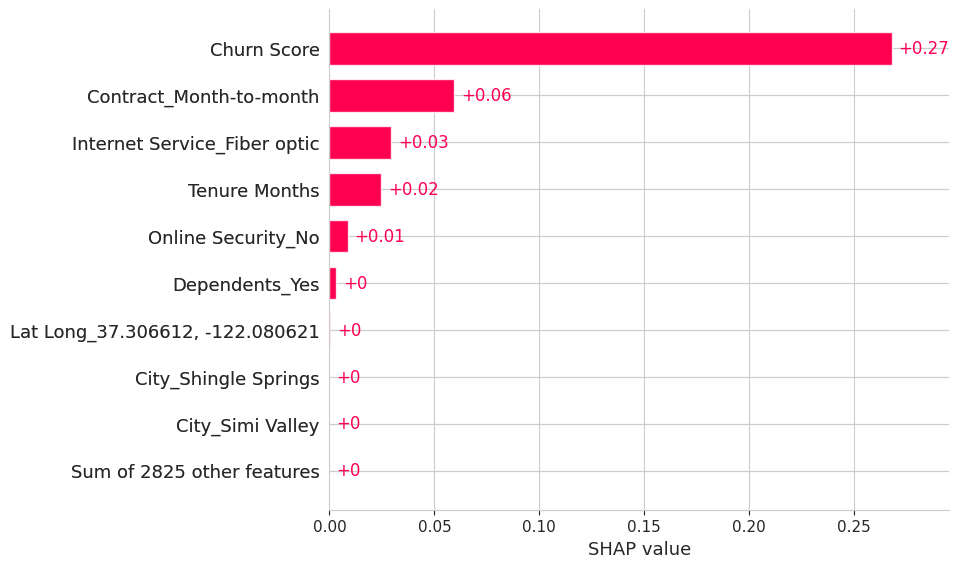

In [123]:
shap_values = explainer.shap_values(X_test)

# Assuming that shap_values is a list where shap_values[1] corresponds to positive class
# You can change the index accordingly if it's different in your case

# Calculate the absolute mean SHAP value for each feature
abs_mean_shap_values = np.mean(np.abs(shap_values[1]), axis=0)

# Create a DataFrame to store feature names and their absolute mean SHAP values
shap_summary_df = pd.DataFrame({'Feature': X_test.columns, 'SHAP Value': abs_mean_shap_values})

# Sort the DataFrame by SHAP value in descending order to get the most important features
shap_summary_df = shap_summary_df.sort_values(by='SHAP Value', ascending=False)

# Print the top N important features (e.g., top 10)
top_n = 10  # Change this value to the number of top features you want to see
print(f"Top {top_n} Important Features:")
print(shap_summary_df.head(top_n))

# Create an Explanation object
explanation = shap.Explanation(values=abs_mean_shap_values,
                               base_values=base_value,
                               feature_names=X_test.columns)

# Generate the bar plot
shap.plots.bar(explanation)

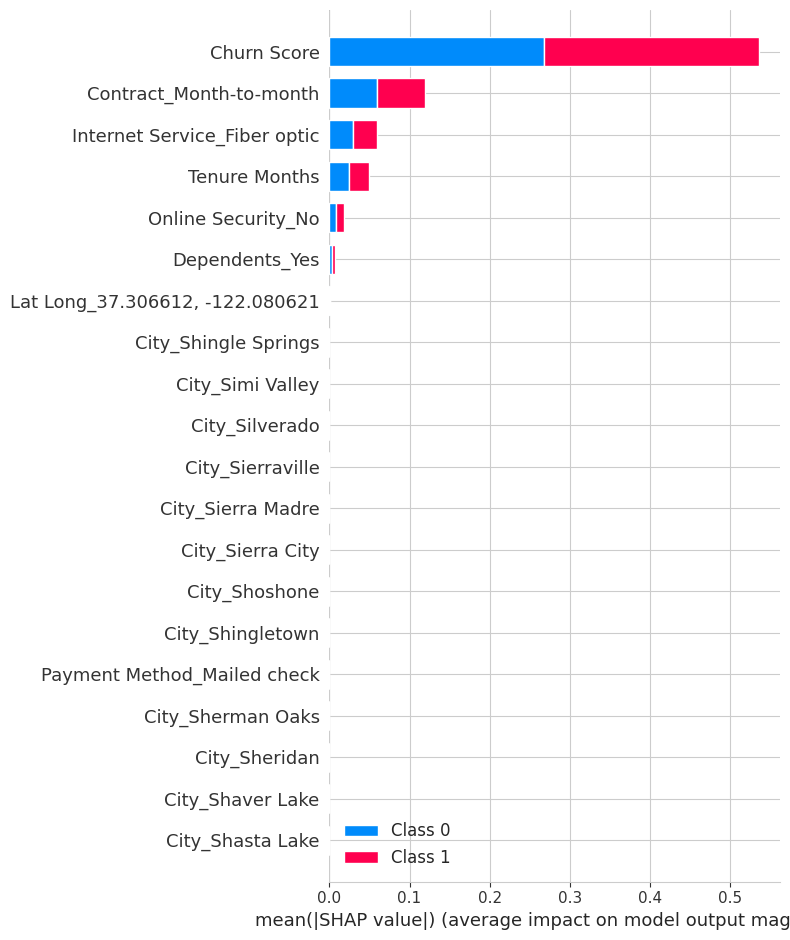

In [124]:
# Generate SHAP values for all test set instances
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Summary plot for all test set instances
shap.summary_plot(shap_values, X_test)

Two most important features according to the LinearRegression model:

1. Churn Score

2. Tenure Months


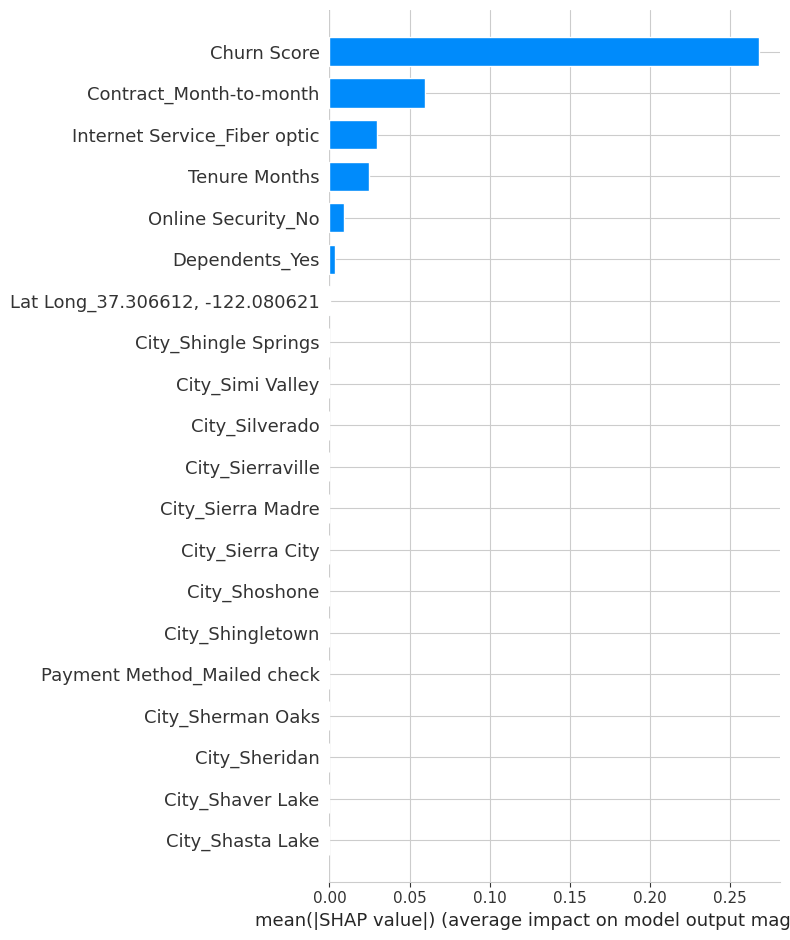

In [125]:
# shap.summary_plot(shap_values.values, X_train, plot_type='bar')
# Summary plot
shap.summary_plot(shap_values[1], X_test, plot_type='bar')

We can interpret the neural network model in the same way

In [129]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer

# Assuming preprocessed_X_train, X_test, y_train, y_test are already defined
# Make sure your target variable (y_train, y_test) is in binary format (0 and 1)

num_epochs = 50
learning_rate = 0.01
hidden_size = 32
batch_size = 50
input_dim = preprocessed_X_train.shape[1]  # Number of features
#batch_no = len(preprocessed_X_train) // batch_size
batch_no = preprocessed_X_train.shape[0] // batch_size

# Re-define the model with the correct input size
model = nn.Sequential(
    nn.Linear(input_dim, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

dense_X_train = preprocessed_X_train.toarray()

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(batch_no):
        start = i * batch_size
        #end = min(start + batch_size, len(preprocessed_X_train))
        end = min(start + batch_size, preprocessed_X_train.shape[0])
        #x_batch = Variable(torch.FloatTensor(preprocessed_X_train[start:end]))
        x_batch = Variable(torch.FloatTensor(dense_X_train[start:end]))

        # Convert y_train[start:end] to a numpy array before creating a tensor
        y_batch = Variable(torch.FloatTensor(y_train[start:end].to_numpy()))

        optimizer.zero_grad()
        y_preds = model(x_batch)
        loss = criterion(y_preds, y_batch.unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {running_loss / batch_no}")

mapper = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)  # Only scale numerical features
    ], remainder='passthrough')  # Keep other features as they are

mapper.fit(X_train)

# Transform both training and test data
preprocessed_X_train = mapper.transform(X_train)
preprocessed_X_test = mapper.transform(X_test)

# Now you can use preprocessed_X_test in your model evaluation
model.eval()  # Set the model to evaluation mode

# For test data
test_preds = model(torch.FloatTensor(preprocessed_X_test)).detach().numpy()
test_preds = (test_preds > 0.5).astype(int).flatten()
test_accuracy = accuracy_score(y_test, test_preds)
print(f"Test Accuracy: {test_accuracy:.3f}")

# For training data (optional)
train_preds = model(torch.FloatTensor(preprocessed_X_train)).detach().numpy()
train_preds = (train_preds > 0.5).astype(int).flatten()
train_accuracy = accuracy_score(y_train, train_preds)
print(f"Train Accuracy: {train_accuracy:.3f}")
train_mae = mean_absolute_error(y_train, train_preds)
test_mae = mean_absolute_error(y_test, test_preds)
print(f"\nTrain MAE = {round(train_mae, 3)}, Test MAE = {round(test_mae, 3)} ")

Epoch 0, Loss: 0.26868594165093135
Epoch 10, Loss: 0.0486130133088279
Epoch 20, Loss: 0.007214687254028311
Epoch 30, Loss: 0.0019815147786630405
Epoch 40, Loss: 0.00010130036464569716
Test Accuracy: 0.877
Train Accuracy: 0.999

Train MAE = 0.001, Test MAE = 0.123 


Epoch 0, Loss: 0.2687: At the beginning of training, the loss is relatively high.
Epoch 10, Loss: 0.0486: After 10 epochs, the loss has decreased significantly.
Epoch 20, Loss: 0.0072: Further reduction in loss after 20 epochs.
Epoch 30, Loss: 0.0020: Continued improvement.
Epoch 40, Loss: 0.0001: The loss has decreased to a very low value after 40 epochs, indicating the model is fitting the training data very well.

**Train MAE and Test MAE:** MAE stands for Mean Absolute Error. It measures the average absolute difference between the predicted values and the actual target values. In your output, both train MAE and test MAE are provided.

  * **Train MAE = 0.001:** The model's predictions on the training data are very close to the actual values, with a very low mean absolute error.

  * **Test MAE = 0.123:** The model's predictions on the test data also have low mean absolute error but are slightly higher than the training data. This is expected because the model may not perform as well on unseen data, but the error is still relatively low.

Most important features for this neural network:

Churn Score

Contract_month-to-month

With this intuition, it's much easier to understand the [math details of Shapely Values](https://christophm.github.io/interpretable-ml-book/shapley.html#the-shapley-value-in-detail).

**References :**


With this intuition, it's much easier to understand the math details of Shapely Values.

Professor's Notebook : https://github.com/ajhalthor/model-interpretability/blob/main/Shap%20Values.ipynb


**License**

Copyright 2023 Mrunali Pawar

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.